<a href="https://colab.research.google.com/github/crisdem/OpenSeesAPI.m/blob/master/Truss_elastic_3_columns_more_complex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Current Domain Information
	Current Time: 1
	Committed Time: 1
NODE DATA: NumNodes: 7

numComponents: 7

 Node: 1
	Coordinates  : 0 0 
	Disps: 2.94278e-07 -6.80272e-08 -8.82833e-08 
	Velocities   : 0 0 0 
	 unbalanced Load: 0 0 0 
	 reaction: 3.55271e-15 5.32907e-15 0 
	ID : 0 1 2 


 Node: 2
	Coordinates  : 14 0 
	Disps: -2.94278e-07 -6.80272e-08 8.82833e-08 
	Velocities   : 0 0 0 
	 unbalanced Load: 0 0 0 
	 reaction: 7.10543e-15 5.32907e-15 0 
	ID : 3 4 5 


 Node: 4
	Coordinates  : 0 -5 
	Disps: 0 0 0 
	 unbalanced Load: 0 0 0 
	 reaction: -0.211968 10 1.05984 
	ID : -1 -1 -1 


 Node: 5
	Coordinates  : 14 -5 
	Disps: 0 0 0 
	 unbalanced Load: 0 0 0 
	 reaction: 0.211968 10 -1.05984 
	ID : -1 -1 -1 


 Node: 6
	Coordinates  : 4.66667 -1.5 
	Disps: -9.87654e-08 -2.00303e-06 0 
	Velocities   : 0 0 0 
	 unbalanced Load: 0 -10 0 
	 reaction: -1.19279e-14 -3.81198e-14 0 
	ID : 6 7 -1 


 Node: 7
	Coordinates  : 9.33333 -1.5 
	Disps: 9.87654e-08 -2.00303e-06 0 
	Velocities   : 0 0 0 
	 u

<Figure size 640x480 with 0 Axes>

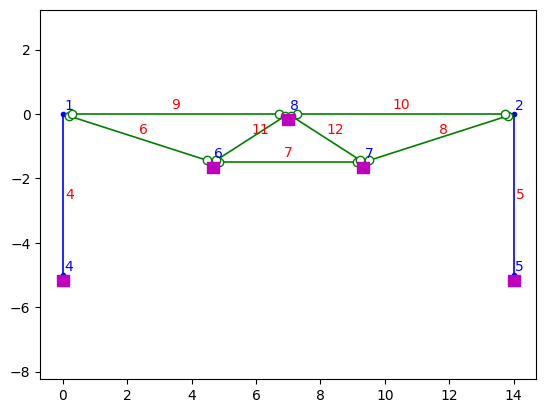

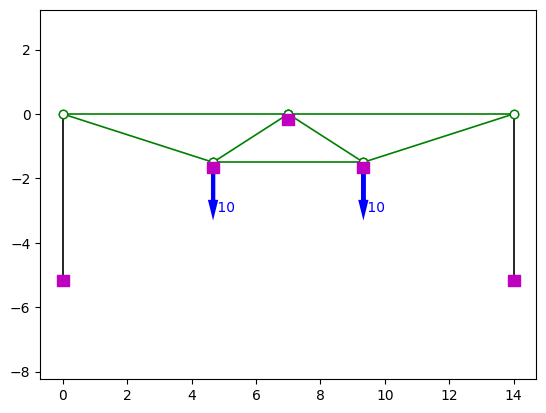

<Figure size 640x480 with 0 Axes>

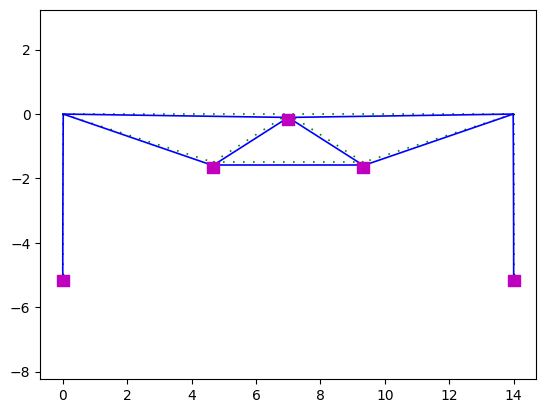

<Figure size 640x480 with 0 Axes>

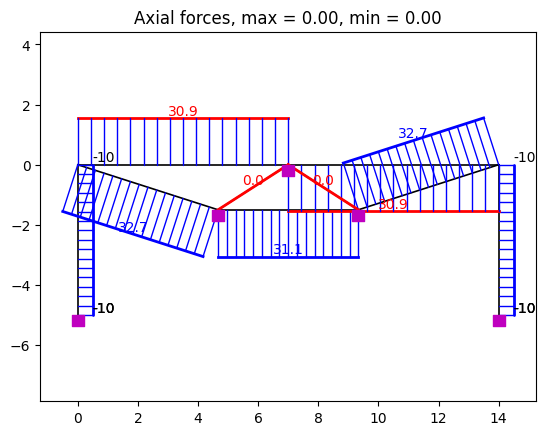

<Figure size 640x480 with 0 Axes>

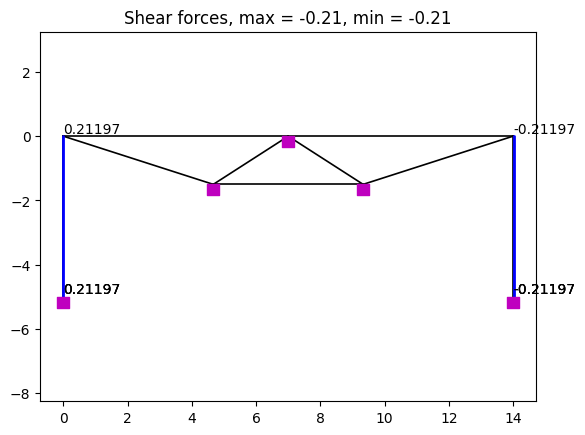

<Figure size 640x480 with 0 Axes>

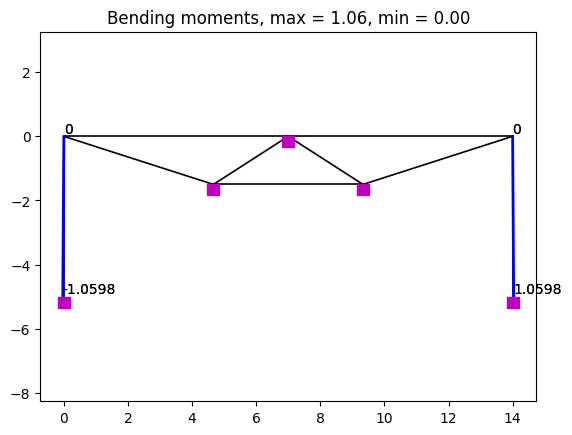

In [7]:
# Install OpenSeesPy
!pip install openseespy
!pip install  opsvis

#%% TITLE
# ------------------------------
# Frame elatic (Linear and Elastic)
# Units: N, m, sec

#%% IMPORT PACKAGES
import openseespy.opensees as ops
import opsvis as opsv
import os
import matplotlib.pyplot as plt

#%% INITIALIZE
# Remove existing model:
ops.wipe()
# Create data directory:
DataDir = r'Output'
if not os.path.exists(DataDir):
    os.makedirs(DataDir)

#%% INPUTS
# Define length:
L=-1.5
L2=14
L3=5.0
# Define cross-section:
B=0.05
H=0.7
D=0.5
# Define elastic modulus
E=2.1e10
E1=1.1e10
# Compute Area
A=3.14*(D/2)**2
A=B*H
I=1./12.*B*H**3
# Set the horizontal force
F=10.

#%% MODEL
# Create ModelBuilder (with two-dimensions and 3 DOF/node):
ops.model('basic', '-ndm', 2, '-ndf', 3)
# Create nodes:
ops.node(1, 0., 0.)
ops.node(2, L2, 0)
ops.node(6, L2/3, L)
ops.node(7, 2*L2/3, L)
ops.node(8, L2/2, 0)
ops.node(4, 0., -L3)
ops.node(5, L2, -L3)

# Set the boundary conditions:
ops.fix(4, 1, 1, 1)
ops.fix(5, 1, 1, 1)

ops.fix(6, 0, 0, 1)
ops.fix(7, 0, 0, 1)
ops.fix(8, 0, 0, 1)

# Define elements:
# Define the material:
ops.uniaxialMaterial('Elastic', 1, E)
ops.uniaxialMaterial('Elastic', 2, E1)
# Define the truss:
ops.element("Truss",6,1,6,A,1)
ops.element("Truss",7,6,7,A,1)
ops.element("Truss",8,2,7,A,1)
ops.element("Truss",9,1,8,A,1)
ops.element("Truss",10,2,8,A,1)
ops.element("Truss",11,6,8,A,1)
ops.element("Truss",12,7,8,A,1)

# Define geometric transformation:
ops.geomTransf('Linear', 1)
ops.geomTransf('Linear', 2)

ops.element('elasticBeamColumn', 4, 4, 1, A, E, I, 1)
ops.element('elasticBeamColumn', 5, 5, 2, A, E, I, 2)

#%% LOADS
# Create a Linear TimeSeries:
#timeSeries Linear 1
ops.timeSeries('Linear', 1)
# Create a Plain load pattern with a linear TimeSeries:
ops.pattern('Plain', 1, 1)
# Create the loads in the linear pattern
#ops.load(6, -F, 0, 0.)
#ops.load(7, -F, 0, 0.)
ops.load(6, 0, -F, 0.)
ops.load(7, 0, -F, 0.)

#%% RECORDER
# Create a recorder for element forces:
ops.recorder('Node', '-file', DataDir+"/Dfree.out",'-time', '-closeOnWrite', '-node', 2, '-dof',1,2,3, 'disp')
# Create a recorder for element forces:
ops.recorder('Node', '-file', DataDir+"/RBase.out",'-time', '-closeOnWrite', '-node', 1, '-dof',1,2,3, 'reaction')
# Create a recorder for element forces:
ops.recorder('Element', '-file', DataDir+"/eleGlobal.out",'-time', '-closeOnWrite', '-ele', 1, 'forces')

#%% ANALYSIS
# Analysis definitions:
# Create the constraint handler, a Plain handler is used as homo constraints:
ops.constraints('Plain')
# Create the DOF numberer, the plain algorithm is used:
ops.numberer('Plain')
# Create the system of equation, a SPD using a band storage scheme:
ops.system('BandSPD')
# Create the solution algorithm, a Linear algorithm is created:
ops.algorithm('Linear')
# Create the integration scheme, the LoadControl scheme using steps of 1.0:
ops.integrator('LoadControl', 1)
# create the analysis object:
ops.analysis('Static')
# Perform the analysis (1 step):
ops.analyze(1)

#%% SCREEN PRINT
# Print the model
ops.printModel()

# 0. plot model with tag lebels
fig = plt.figure()
opsv.plot_model()

# 1. plot supports and loads
opsv.plot_load()

# 2. plot deformed model
plt.figure()

sfac = 50000
opsv.plot_defo(sfac)

# 3. plot N, V, M forces diagrams
sfacN, sfacV, sfacM = 1/20, 1/10, 1/32

plt.figure()
minVal, maxVal, _ = opsv.section_force_diagram_2d('N', sfacN)
plt.title(f'Axial forces, max = {maxVal:.2f}, min = {minVal:.2f}')

plt.figure()
minVal, maxVal, _ = opsv.section_force_diagram_2d('T', sfacV)
plt.title(f'Shear forces, max = {maxVal:.2f}, min = {minVal:.2f}')

plt.figure()
minVal, maxVal, _ = opsv.section_force_diagram_2d('M', sfacM)
plt.title(f'Bending moments, max = {maxVal:.2f}, min = {minVal:.2f}')

plt.show()
